In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numpy import cos, sin
from numpy.linalg import norm
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from API import api_get
from propagation import jacobi as prop_jacobi
import plotting
import manifold_tools
import poincare_tools

In [16]:
def fourbody_4(t, x): 
    """ The ODE function for the orbit in the BCR4BP in the Earth-Sun centered frame
    
    Inputs:
    - t: the time
    - x: A numpy array of 4 elements, the orbit states x, y, x_dot, y_dot
    - params: A dictionary containing associated problem parameters
    """

    mu = 0.012150584673414
    mu_s = 328900
    A1 = 0.00116
    A2 = 382.7275
    theta_S_dot = 0.0766

    xdot = np.zeros((4,))
    xdot[0:2] = x[2:4]
    #theta_S_dot = np.sqrt((mu_s + 1)/(A1 + A2) ** 3)
    theta_S = theta_S_dot * t
    theta_e = t

    xs = -(A1 + A2) * np.cos(theta_S - theta_e)
    ys = -(A1 + A2) * np.sin(theta_S - theta_e)

    r_e = np.sqrt((x[0] + mu)**2. + x[1]**2.) 
    r_m = np.sqrt((x[0] - 1. + mu)**2. + x[1]**2.)
    r_s = np.sqrt((x[0] - xs)**2. + (x[1] - ys)**2.)

    xdot[2] = x[0] + 2 * x[3] - (1-mu) * (x[0]+mu)/(r_e**3) - mu * (x[0]-1+mu)/(r_m**3) - mu_s * (x[0] - xs)/(r_s**3) + A2 * theta_S_dot**2 * np.cos(theta_S-theta_e)
    
    xdot[3] = x[1] - 2 * x[2] - (1-mu) * x[1]/(r_e**3) - mu * x[1]/(r_m**3) - mu_s * (x[1] - ys)/(r_s**3) + A2 * theta_S_dot**2 * np.sin(theta_S-theta_e)
    
    #xdot[5] = - (1 - mu) * x[2] / (r_e**3) - mu * x[2] / (r_m**3) - mu_s * x[2] / (r_s**3)

    return xdot

In [13]:
def fourbody_correct(t, x): 
    """ The ODE function for the orbit in the BCR4BP in the Earth-Sun centered frame
    
    Inputs:
    - t: the time
    - x: A numpy array of 4 elements, the orbit states x, y, x_dot, y_dot
    - params: A dictionary containing associated problem parameters
    """

    

    mu = 0.012150584673414
    mu_s = 328900
    A1 = 0.00116
    A2 = 382.7275
    theta_S_dot = 0.0766

    xdot = np.zeros((4,))
    x = [x[0], x[1], 0, x[2], x[3], 0]
    xdot[0:2] = x[2:4]
    #theta_S_dot = np.sqrt((mu_s + 1)/(A1 + A2) ** 3)
    theta_S = theta_S_dot * t
    theta_e = t

    xs = -(A1 + A2) * np.cos(theta_S - theta_e)
    ys = -(A1 + A2) * np.sin(theta_S - theta_e)

    r_e = np.sqrt((x[0] + mu)**2. + x[1]**2. + x[2]**2.) 
    r_m = np.sqrt((x[0] - 1. + mu)**2. + x[1]**2. + x[2]**2.)
    r_s = np.sqrt((x[0] - xs)**2. + (x[1] - ys)**2. + x[2]**2.)

    xdot[3] = x[0] + 2 * x[4] - (1-mu) * (x[0]+mu)/(r_e**3) - mu * (x[0]-1+mu)/(r_m**3) - mu_s * (x[0] - xs)/(r_s**3) + A2 * theta_S_dot**2 * np.cos(theta_S-theta_e)
    
    xdot[4] = x[1] - 2 * x[3] - (1-mu) * x[1]/(r_e**3) - mu * x[1]/(r_m**3) - mu_s * (x[1] - ys)/(r_s**3) + A2 * theta_S_dot**2 * np.sin(theta_S-theta_e)
    
    #xdot[5] = - (1 - mu) * x[2] / (r_e**3) - mu * x[2] / (r_m**3) - mu_s * x[2] / (r_s**3)

    return xdot

In [22]:
def fourbody(t, x):
    """
    The ODE function for the orbit in the BCR4BP in the Sun - B1 frame

    Inputs:
    - t: The time
    - x: A numpy array of 6 elements, the orbit states x, y, x_dot, y_dot
    """
    mu  = 1.21506683E-2 # Earth-Moon Mass Parameter 
    ms  = 3.28900541E+5 # Scaled Mass of the Sun
    rho = 3.88811143E+2 # Scaled Sun-(Earth-Moon) Distance 
    oms = 9.25195985E-1 # Scaled Angular Velocity of the Sun
    ths = oms*t
    
    r1 = np.sqrt((x[0]+mu)**2   + x[1]**2)
    r2 = np.sqrt((x[0]+mu-1)**2 + x[1]**2)
    r3 = np.sqrt((x[0] - rho*np.cos(ths))**2 + (x[1] - rho*np.sin(ths))**2)

    a  = x[0] - (1-mu)*(x[0]+mu)/r1**3 - mu*(x[0]+mu-1)/r2**3
    b  = -(x[0] - rho*np.cos(ths)) / r3**3
    c  = np.cos(ths)

    d  = x[1] - (1-mu)*x[1]/r1**3 - mu*x[1]/r2**3
    e  = -(x[1] - rho*np.sin(ths)) / r3**3
    f  = np.sin(ths)

    xdot = [x[2],
        x[3],
        2*x[3] + a + ms*b - ms/rho**2*c,
        -2*x[2] + d + ms*e - ms/rho**2*f]

    return xdot

def fourbody_ES(t, x, mu):
    """ The ODE function for the orbit in the BCR4BP in the Earth-Sun centered frame
    
    Inputs:
    - t: the time
    - x: A numpy array of 4 elements, the orbit states x, y, x_dot, y_dot
    - mu: The CR3BP mass-ratio parameter.
    """
    xdot = threebody_orbit(t, x, mu) 

    LU = 1.49598E+8 # Earth-Sun distance, or 1 AU, [km]
    TU = 5022635 # seconds
    # tau = # Time non-dim scaling factor

    mu_m = 4.9028695E+3 # Gravitational parameter of the Moon [km^3 s^-2]
    R_m = 384400 / LU # Orbital radius of the Moon about the Earth [-]
    moon_earth_orbit_seconds = 2360591.78
    w_m = 2*math.pi/moon_earth_orbit_seconds # Angular velocity of the Moon about the Earth

    r_m = [1-mu + R_m * np.cos(w_m * t),
            R_m * np.cos(w_m * t)] 

    r = x[0:2] - r_m # Vector from S/C to the Moon
    
    a2b = -mu_m * r / np.norm(r) ** 3

    a2b = a2b * TU**2/LU # Non-dimensionalize acceleration

    xdot[2:4] += a2b

    return xdot

def threebody_orbit(t, x, mu):
    """
    The ODE function for the orbit in the CR3BP

    Inputs:
    - t: The time
    - x: A numpy array of 4 elements, the orbit states x, y, x_dot, y_dot
    - mu: The only parameter of importance in the CR3BP
    """
    r = np.linalg.norm(x[0:2])

    xdot = np.empty((4,))
    xdot[0:2] = x[2:5]

    r1 = np.sqrt((x[0] + mu)**2. + x[1]**2.)
    r2 = np.sqrt((x[0] - 1. + mu)**2. + x[1]**2.)

    xdot[2] = 2.*x[3] + x[0] - ((1. - mu)*(x[0] + mu)/(r1**3.)) - (mu*(x[0] - 1. + mu)/(r2**3.))
    xdot[3] = -2.*x[2] + x[1] - ((1. - mu)*x[1]/(r1**3.)) - (mu*x[1]/(r2**3.))
    #xdot[5] = -((1. - mu)*x[2]/(r1**3.)) - (mu*x[2]/(r2**3.))

    return xdot

def Syn2ECI(t, x, mu):
    size = np.shape(x)
    xECI  = np.zeros(size)

    xECI[0,:] = (x[0,:] + mu)*np.cos(t[:]) - x[1,:]*np.sin(t[:])
    xECI[1,:] = (x[0,:] + mu)*np.sin(t[:]) + x[1,:]*np.cos(t[:])
    xECI[2,:] = (x[2,:] - x[1,:])*np.cos(t[:]) - (x[3,:] + x[0,:] + mu)*np.sin(t[:])
    xECI[3,:] = (x[2,:] - x[1,:])*np.sin(t[:]) + (x[3,:] + x[0,:] + mu)*np.cos(t[:])

    return xECI

def jacobi_guess(v0, mu, C_des, r0, deg):
    """
    Find the v0 necessary to maintain a set Jacobi Constant in CR3BP Parking orbit. For use with fsolve
    Args:
        v0 (float): Delta V applied in parking orbit to match desired Jacobi Constant
        mu (float): mass-ratio
        C_des (float): Jacobi Constant to match
        r0 (float): Parking orbit radius, ND
        deg (float): Angle around Earth

    Returns:
        C - C_Des (float): Difference between computed and desired Jacobi
    """
    states = [(r0*np.cos(deg) + (1 - mu)), 
        r0*np.sin(deg), 
        -(v0 - r0) * np.sin(deg), # v0 replaced with 0
        (v0 - r0) * np.cos(deg)] # v0 replaced with 0
    
    x = states[0]; y = states[1]
    x_dot = states[2]; y_dot = states[3]
    
    r = np.sqrt((x - 1 + mu)**2 + y**2)
    d = np.sqrt((x + mu)**2 + y**2 )
    U = (x**2 + y**2) / 2 + mu / r + (1 - mu) / d
    v = np.sqrt(x_dot**2 + y_dot**2)
    C = 2 * U - v**2
    
    return C - C_des

def periapse_stop(t, y, mu):
    # https://deepblue.lib.umich.edu/bitstream/handle/2027.42/42568/10569_2004_Article_405.pdf?sequence=1 (7)
    r = y[0:2] - [1-mu,0]
    r_dot = y[2:4]
    
    return np.dot(r, r_dot)
    




In [30]:
mu = 0.012150584673414
mu_s = 328900
m_moon = 7.34767309E22 # Kg
A1 = 0.00116
A2 = 382.7275
theta_S_dot = 0.0766
t = [0]
x = np.array([-A2, 0, 0, 0]).reshape(4,1)
print(Syn2ECI(t, x, mu_s))

[[-382.71534942]
 [   0.        ]
 [   0.        ]
 [-382.71534942]]


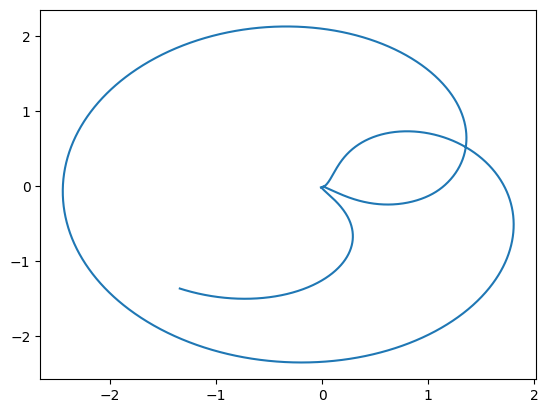

In [26]:
G = 6.6743E-20 # km**3 kg**-1 s**-2
radius_earth = 6378 # km

# Topputo Two Impulse Paper

DU  = 3.84405000E+5 # Distance Unit [km]
TU  = 4.34811305 # Time Unit [days]
VU  = 1.02323281E+3 # Speed Unit [km][s-1]

mu = 1.21506683E-2 # Earth-Moon Mass Parameter 
r0 = (radius_earth + 167) / DU
deltaV = 0

alpha = 1.5*np.pi # Angle
beta = 1.41
v0 = beta*np.sqrt((1-mu)/r0)

y0 = [(r0*np.cos(alpha) - mu), 
    r0*np.sin(alpha), 
    -(v0 - r0) * np.sin(alpha), 
    (v0 - r0) * np.cos(alpha)]

t_vec_temp = np.linspace(0, 10, num=3000) 

sol = solve_ivp(fourbody_4, [t_vec_temp[0], t_vec_temp[-1]], y0, 
        method = 'DOP853', t_eval = t_vec_temp, rtol=1e-10, atol=1e-10)

fig = plt.figure()
ax0 = plt.axes()
ax0.plot(sol.y[0], sol.y[1])
   


C:\Users\kaiya\AppData\Local\Temp\ipykernel_1228\3831045117.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v0s[i] = v0 * (1000 * DU / TU) # Save the insertion delta-V in [m/s]


KeyboardInterrupt: 

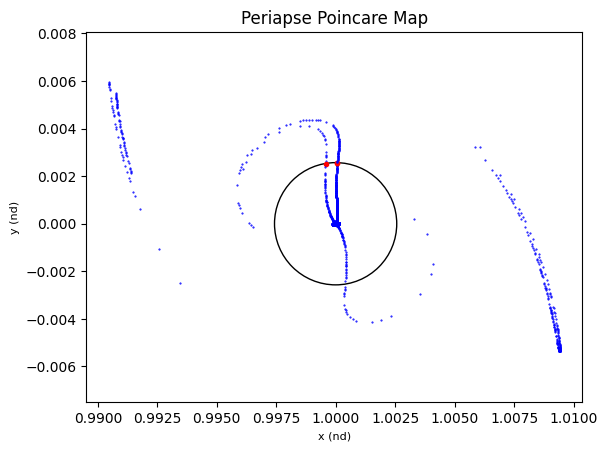

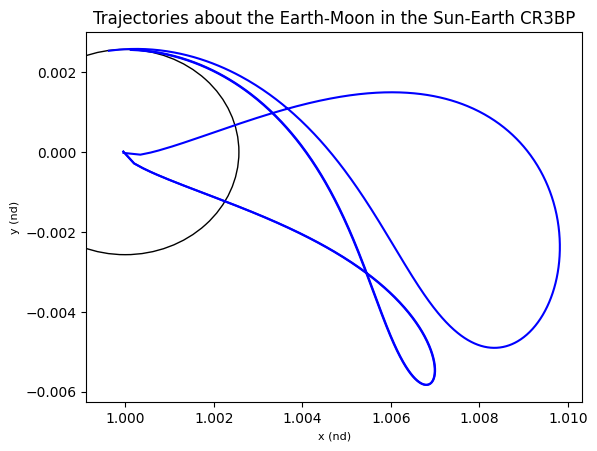

In [23]:
# Scheuler paper
# Parameters of Sun-Earth system
mu = 3.054200000000000E-6 # Sun - Earth Mass Parameter
DU = 149597871 # Distance Unit km, 1AU
TU = 5022635 # Time Unit s

# Initial conditions parking orbit around Earth
C = 3.000804

r0 = (radius_earth + 150) / DU # 150 km parking orbit, non-dimensionalized

points = 5000
alpha = np.linspace(0, 2*np.pi, points)

ICs = np.zeros([points, 4]) 
v0s = np.zeros(points)
transfer_times = np.zeros(points)

# Perigee Calculation

s_year = 60*60*24*365

t_vec_temp = np.linspace(0, s_year / TU, num=3000) # 365 day propagation
periapse = lambda t, y : periapse_stop(t, y, mu)
periapse.terminal = True
periapse.direction = 1

# Poincare Map
fig = plt.figure(); ax = plt.axes()
y_f = 384400 / 149597871 # Nd Moon radius
circle2 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax.add_artist(circle2)
ax.axis('equal')
plt.title('Periapse Poincare Map')
plt.xlabel('x (nd)', fontsize=8); plt.ylabel('y (nd)', fontsize=8)

# Trajectories of orbits that get to the moon
fig2 = plt.figure(); ax2 = plt.axes()
circle3 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax2.add_artist(circle3)
plt.title('Trajectories about the Earth-Moon in the Sun-Earth CR3BP')
plt.xlabel('x (nd)', fontsize=8); plt.ylabel('y (nd)', fontsize=8)


threebody = lambda t, state : threebody_orbit(t, state, mu)
valid_orbits = 0 # Count how many orbits meet our condition
threebody_guesses = np.zeros([6,])

for i in range(points):
    deg = alpha[i]
    jacobi = lambda v0 : jacobi_guess(v0, mu, C, r0, deg)
    v0 = fsolve(jacobi, np.sqrt((1-mu)/r0)) # Find the delta-V to maintain Jacobi Constant
    v0s[i] = v0 * (1000 * DU / TU) # Save the insertion delta-V in [m/s]
    ICs[i,:] = [(r0*np.cos(deg) + (1 - mu)), 
                r0*np.sin(deg), 
                -(v0[0] - r0) * np.sin(deg),
                (v0[0] - r0) * np.cos(deg)]


    sol = solve_ivp(threebody, [t_vec_temp[0], t_vec_temp[-1]], ICs[i,:], 
        method = 'DOP853', t_eval = t_vec_temp, rtol=1e-10, atol=1e-10, events = periapse)
    
    if sol.y_events[0].any(): # Was apse ever achieved?
        for event in sol.y_events[0]: 
            r = event[0:2] - [1-mu,0]
            r_dot = event[2:4]
            r_dotdot = threebody_orbit(0, event, mu)
            
            if np.linalg.norm(r_dot)**2 + np.dot(r, r_dotdot[2:4]) > 0: # Was the event a periapse? Apoapse if D<0 [craig-davis thesis, 33]
                ax.plot(event[0], event[1], 'b.', markersize=1)
                if abs(np.linalg.norm(r) - y_f) <= 1780/DU: # Was the periapse within moon parking orbit?
                    ax2.plot(sol.y[0], sol.y[1], 'b')    
                    ax.plot(event[0], event[1], 'r.')
                    #transfer_times[i] = sol.t_events[0] * TU / 86400 # Record Transfer Time in Days
                    guess = np.concatenate((ICs[i, :], [deg, v0[0]]))
                    threebody_guesses = np.vstack((threebody_guesses, guess))
                    valid_orbits += 1
                    
print(f'Found {valid_orbits} valid orbits.')

ax.axis('equal')
ax.set_xlim([1-mu -5E+5 / DU, 1-mu + 5E+5/ DU])
ax.set_ylim([-5E+5 / DU, 5E+5 / DU])

ax2.axis('equal')
ax2.set_xlim([1 -12E+5 / DU, 1 + 12E+5 / DU])
ax2.set_ylim([-12E+5 / DU, 12E+5 / DU])

threebody_guesses = np.delete(threebody_guesses,0,0)
np.save('threebody_guesses', threebody_guesses)